In [1]:
%matplotlib inline
import os
from pathlib import Path
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix, parallel_coordinates
import seaborn as sns
import matplotlib.pylab as plt
import warnings
import re
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
train      = pd.read_csv("train_data.csv")
test       = pd.read_csv("test_data.csv")
topic_dict = pd.read_csv("topic_dict.csv")

In [3]:
topic_dict

,topic,topic_idx
0,IT과학,0
1,경제,1
2,사회,2
3,생활문화,3
4,세계,4
5,스포츠,5
6,정치,6


In [4]:
test

,index,title
0,45654,유튜브 내달 2일까지 크리에이터 지원 공간 운영
1,45655,어버이날 맑다가 흐려져…남부지방 옅은 황사
2,45656,내년부터 국가RD 평가 때 논문건수는 반영 않는다
3,45657,김명자 신임 과총 회장 원로와 젊은 과학자 지혜 모을 것
4,45658,회색인간 작가 김동식 양심고백 등 새 소설집 2권 출간
...,...,...
9126,54780,인천 오후 3시35분 대설주의보…눈 3.1cm 쌓여
9127,54781,노래방에서 지인 성추행 외교부 사무관 불구속 입건종합
9128,54782,40년 전 부마항쟁 부산 시위 사진 2점 최초 공개
9129,54783,게시판 아리랑TV 아프리카개발은행 총회 개회식 생중계


In [5]:
train

,index,title,topic_idx
0,0,인천→핀란드 항공기 결항…휴가철 여행객 분통,4
1,1,실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화,4
2,2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4
3,3,NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합,4
4,4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4
...,...,...,...
45649,45649,KB금융 미국 IB 스티펠과 제휴…선진국 시장 공략,1
45650,45650,1보 서울시교육청 신종코로나 확산에 개학 연기·휴업 검토,2
45651,45651,게시판 키움증권 2020 키움 영웅전 실전투자대회,1
45652,45652,답변하는 배기동 국립중앙박물관장,2


In [6]:
#train=train.reset_index(drop=False)
train=train.set_index('index')
train

,title,topic_idx
index,,
0,인천→핀란드 항공기 결항…휴가철 여행객 분통,4
1,실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화,4
2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4
3,NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합,4
4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4
...,...,...
45649,KB금융 미국 IB 스티펠과 제휴…선진국 시장 공략,1
45650,1보 서울시교육청 신종코로나 확산에 개학 연기·휴업 검토,2
45651,게시판 키움증권 2020 키움 영웅전 실전투자대회,1


In [7]:
train.dtypes

title        object
topic_idx     int64
dtype: object

데이터 타입 확인

In [8]:
# Check for missing data 
train.isna().any().any()

False

In [9]:
train.isna().sum()

title        0
topic_idx    0
dtype: int64

결측값 확인시 결측 없음

In [10]:
categorical = [1,2,3,4,5,6]
train["topic_idx"] = train["topic_idx"].astype("category")

In [11]:
train["topic_idx"].value_counts().sort_index()

0    4824
1    6222
2    7362
3    5933
4    7629
5    6933
6    6751
Name: topic_idx, dtype: int64

In [12]:
train.dtypes

title          object
topic_idx    category
dtype: object

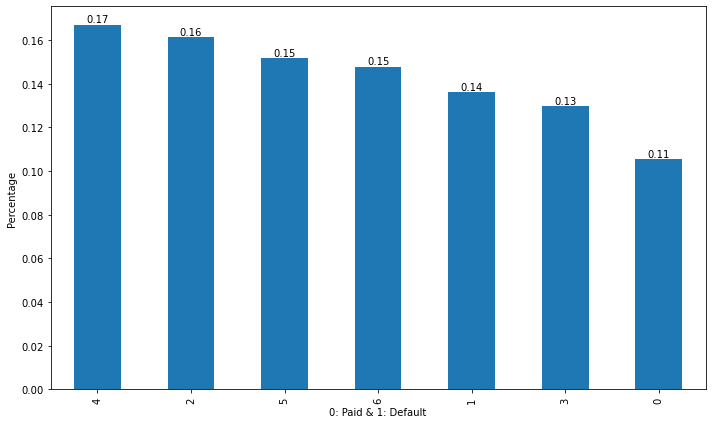

In [13]:
target = train["topic_idx"].value_counts() / len(train)
ax = target.plot(kind="bar", figsize=[10,6])

ax.bar_label(ax.containers[0], fmt="%.2f")
ax.set_xlabel("0: Paid & 1: Default")
ax.set_ylabel("Percentage")
plt.tight_layout()
plt.show()

범주형으로 데이터 형식 변경해 확인
4번이 제일 높게 나타남 - 세계

C:\Users\ajm10\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


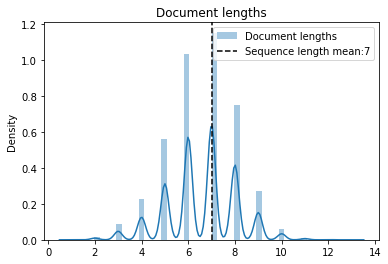

 가장 긴 문장은 13 개의 단어
 가장 짧은 문장은 1 개의 단어


In [14]:
# 문장 길이 분포도 확인
train['doc_len'] = train.title.apply(lambda words: len(words.split()))

def plot_doc_lengths(dataframe):
    mean_seq_len = np.round(dataframe.doc_len.mean()).astype(int)
    sns.distplot(tuple(dataframe.doc_len), hist=True, kde=True, label='Document lengths')
    plt.axvline(x=mean_seq_len, color='k', linestyle='--', label=f'Sequence length mean:{mean_seq_len}')
    plt.title('Document lengths')
    plt.legend()
    plt.show()
    print(f" 가장 긴 문장은 {train['doc_len'].max()} 개의 단어\n 가장 짧은 문장은 {train['doc_len'].min()} 개의 단어")

plot_doc_lengths(train)

평균 길이 20

##  워드 클라우드 분석

In [48]:
train.loc[train["topic_idx"]==0]

,title,topic_idx,doc_len,cleaned_title
index,,,,
617,지카바이러스도 규명한 초저온전자현미경…신약연구에 유용,0,4,지카바이러스도 규명한 초저온전자현미경 신약연구에 유용
622,증강현실 ① 알파고 이어 포켓몬 고…거센 IT 광풍,0,8,증강현실 알파고 이어 포켓몬 고 거센 광풍
643,AI 월드컵 생생한 현장 중계도,0,5,월드컵 생생한 현장 중계도
654,이세돌 알파고 집중력 사람이 이기긴 어렵다 일문일답종합2보,0,7,이세돌 알파고 집중력 사람이 이기긴 어렵다 일문일답종합 보
660,올해 휴대폰 국내 생산량 2천500만대…10년전의 18.4%,0,6,올해 휴대폰 국내 생산량 천 만대 년전의
...,...,...,...,...
45605,화성 적도에서 상당량 수소 발견…물 존재 가능성,0,7,화성 적도에서 상당량 수소 발견 물 존재 가능성
45606,갤S8 색감 조정하면 된다는 삼성…해외 반응이 관건,0,7,갤 색감 조정하면 된다는 삼성 해외 반응이 관건
45613,알코올 중독 유전적 연관성 더 확실해졌다,0,6,알코올 중독 유전적 연관성 더 확실해졌다


In [32]:
df_list = []
for i in range(7):
    df_list.append(train.loc[train.topic_idx==i])

In [33]:
title_list = []
for i in range(7):
    title_list.append(df_list[i].title.to_numpy())

In [34]:
filter_pos = ['NNP', 'NNG','SL']# 명사, 외래어 출력

In [36]:
token_sentence_list = []
for i in range(7):
    titles = title_list[i]
    token_sentences = [word for text in titles for word, pos in mecab.pos(text) if pos in filter_pos]
    token_sentence_list.append(token_sentences)

NameError: name 'mecab' is not defined